In [1]:
## This Cell is related to date preprocessing and is completely copied from original kipf's github code!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch,torch.nn,torch.sparse,torch.nn.functional,torch.distributions
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.inf)


from google.colab import drive
drive.mount('/content/drive')


W_gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/gene.txt", delim_whitespace=True).to_numpy()
W_methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/methy.txt", delim_whitespace=True).to_numpy()
W_mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/mirna.txt", delim_whitespace=True).to_numpy()

gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Gene_Expression.txt", delim_whitespace=True).to_numpy().transpose()
methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Methy_Expression.txt", delim_whitespace=True).to_numpy().transpose()
mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Mirna_Expression.txt", delim_whitespace=True).to_numpy().transpose()
truelabel =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Survival.txt", delim_whitespace=True).to_numpy()



print(gene.shape)
print(methy.shape)
print(mirna.shape)

def get_nomralized_laplacian(a):
    b = np.diag(np.power(1.0 / a.sum(axis=1), 0.5))
    return (b @ a @ b)





features = np.c_[mirna,methy,gene]
features = features/30 + 0.5

patient_no = features.shape[0]

idx = np.arange(patient_no)
np.random.shuffle(idx)
train_idx = idx[0:int(patient_no * 0.75)]
val_idx =   idx[int(patient_no * 0.75):]

train_features = features[train_idx]
train_features = features
val_features   = features[val_idx]
print(train_features.shape)
print(val_features.shape)




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: read_table is deprecated, use read_csv inste

(215, 12042)
(215, 1305)
(215, 534)
(215, 13881)
(54, 13881)


In [0]:
#print(train_features.max())
#print(train_features.min())
#print(my_model.x_prim)


print((torch.log(my_model.x_prim)*train_features_tensor + torch.log(1-my_model.x_prim)*(1-train_features_tensor)).min())

NameError: ignored

In [0]:
#Model definition Cell

num_features = features.shape[1]

train_features_tensor  = torch.Tensor(train_features)
val_features_tensor    = torch.Tensor(val_features)





class Model(torch.nn.Module):

    def __init__(self,**kwargs):
        super(Model, self).__init__(**kwargs)
        
        
        
            

        self.W0 = torch.nn.Linear(num_features,500)
        self.W1 = torch.nn.Linear(500,100)
        self.W2 = torch.nn.Linear(100,500)
        self.W3 = torch.nn.Linear(500,num_features)

        self.drouput1 = torch.nn.Dropout(p=0.5)
        self.drouput2 = torch.nn.Dropout(p=0.5)
        
        param_list = []
        param_list += list(self.W0.parameters())
        param_list += list(self.W1.parameters())
        param_list += list(self.W2.parameters())
        param_list += list(self.W3.parameters())
        
        

        self.optimizer = torch.optim.Adam(param_list,lr=0.001)
        self.recon = None
        
        self.normal_dist = torch.distributions.MultivariateNormal(loc=torch.zeros(100),scale_tril=torch.eye(100))

        
        
        
    


        
    def forward(self,x) : 
        self.layer_1 = torch.nn.functional.tanh(self.W0(self.drouput1(x)))
        self.layer_2 = torch.nn.functional.tanh(self.W1(self.drouput2(self.layer_1)))
        self.layer_3 = torch.nn.functional.tanh(self.W2(self.layer_2+self.normal_dist.sample((x.shape[0],))))
        #self.layer_3 = torch.nn.functional.tanh(self.W2(self.layer_2))

        self.layer_4 = torch.nn.functional.sigmoid(self.W3(self.layer_3))
        
        

        self.x_prim = self.layer_4
        self.embedding = self.layer_2
        
        self.recon_loss = ((self.x_prim-x)**2).mean(0)
        self.recon_loss = self.recon_loss[0:534].mean()+self.recon_loss[534:534+1305].mean()+self.recon_loss[534+1305:534+1305+12042].mean()
        self.recon_loss = self.recon_loss/3

        # self.recon_loss = x * torch.log(self.x_prim) + (1-x) * torch.log(1-self.x_prim)
        # self.recon_loss = self.recon_loss[:,0:534].mean(1)+self.recon_loss[:,534:534+1305].mean(1)+self.recon_loss[:,534+1305:534+1305+12042].mean(1)
        # self.recon_loss = self.recon_loss.mean(0)
        # self.recon_loss = -1*self.recon_loss
       
        self.l1_regularization =  (torch.norm(list(self.W0.parameters())[0],1))+(torch.norm(list(self.W1.parameters())[0],1))

        #print(self.l1_regularization)
        self.KL_loss = (self.embedding**2).mean(1).mean(0)
        
        self.loss = self.recon_loss+self.KL_loss/50+self.l1_regularization/1000000
        print(self.recon_loss.item(),self.KL_loss.item()/50,self.l1_regularization.item()/1000000)

        #self.l1_regularization/1000000
       
        
        
        
        
        
        return self.loss.item()
        
    def backward(self) :
        
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

        
        
    def get_cosine_sim_emb(self):
        
        emb = self.embedding.detach().numpy()

        norms =  (emb*emb).sum(1).reshape(-1,1)**0.5
        normalized_emb = emb/norms

        emb_matrix = np.abs( normalized_emb@normalized_emb.transpose())
        return emb_matrix
        

    def get_euclidian(self):
        emb = self.embedding.detach().numpy()
        
        emb_matrix = np.zeros((emb.shape[0],emb.shape[0]))
        
        for i in range(emb.shape[0]):
            for j in range(emb.shape[0]):
                emb_matrix[i,j] = ((emb[i]-emb[j])**2).sum()
                
        return emb_matrix
        
        



In [3]:
#Training Cell 

my_model = Model()


for epoch_counter in range(1000):
    
    train_loss = my_model.forward(train_features_tensor)
    my_model.backward()
    val_loss = my_model.forward(val_features_tensor)
    my_model.optimizer.zero_grad()
    val_loss = 0

    if epoch_counter % 1 ==0:
        print("Epoch:", '%04d' % (epoch_counter + 1), "train_loss=", "{:.5f}".format(train_loss), "val_loss=", "{:.5f}".format(val_loss))


print('\n',"#########################################################",'\n')






/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.005573326256126165 0.0014237400889396668 0.030560419921875
0.006191214546561241 0.009408907294273376 0.030140541015625
Epoch: 0001 train_loss= 0.03756 val_loss= 0.00000
0.006237159017473459 0.009461241364479065 0.030140541015625
0.005331383552402258 0.00725736677646637 0.02921036328125
Epoch: 0002 train_loss= 0.04584 val_loss= 0.00000
0.0054324716329574585 0.0071687960624694826 0.02921036328125
0.005103807430714369 0.005727744698524475 0.02798002734375
Epoch: 0003 train_loss= 0.04181 val_loss= 0.00000
0.005091588944196701 0.005704683661460877 0.02798002734375
0.004877729807049036 0.005116758346557618 0.02661096875
Epoch: 0004 train_loss= 0.03878 val_loss= 0.00000
0.004841713234782219 0.005059980750083923 0.02661096875
0.004629093687981367 0.0052714604139328 0.025180228515625
Epoch: 0005 train_loss= 0.03651 val_loss= 0.00000
0.004562768619507551 0.0051243042945861815 0.025180228515625
0.004190841224044561 0.005332683324813843 0.023730052734375
Epoch: 0006 train_loss= 0.03487 val_loss=

KeyboardInterrupt: ignored

In [4]:
my_model.forward(train_features_tensor)
my_model.drouput1.eval()
my_model.drouput2.eval()

#my_model.drouput1.train()
#my_model.drouput2.train()

print(my_model.forward(train_features_tensor))

0.0011265105567872524 3.3373984479112553e-07 0.0005085119323730468
0.0011243288172408938 2.833113103406504e-07 0.0005085119323730468
0.0016331240767613053


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [5]:
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
np.savetxt("/content/drive/My Drive/Data Fusion/results/emb_v49.txt",emb,delimiter='\t')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.0011247550137341022 2.833113103406504e-07 0.0005085119323730468


In [0]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
emb = np.loadtxt("/content/drive/My Drive/Data Fusion/results/emb_v11.txt",delimiter='\t')

[1, 1, 1, 1, 1]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.0011300184996798635 2.833113103406504e-07 0.0005085119323730468


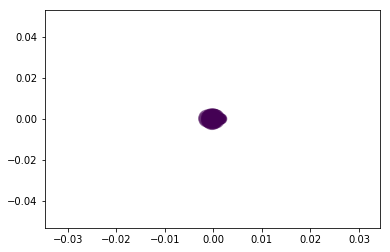

In [6]:
####PCA on embedding
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
circle_areas = (truelabel[:,1].astype(float)/8)
X_embedded = PCA(n_components=2).fit_transform(emb)
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], s=circle_areas, c= 1*np.ones(215), alpha=0.5)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.0011285921791568398 2.833113103406504e-07 0.0005085119323730468


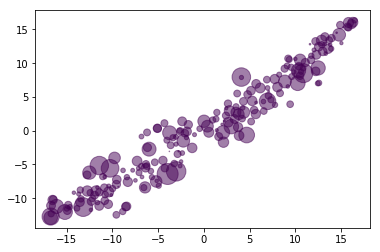

In [7]:
### TSNE on embedding
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
circle_areas = (truelabel[:,1].astype(float)/8)
X_embedded = TSNE(n_components=2).fit_transform(emb)
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], s=circle_areas, c= 1*np.ones(215), alpha=0.5)
plt.show()

In [0]:
from sklearn.cluster import KMeans
X = emb
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

for i in range(n_clusters):
    indx = np.argwhere(kmeans.labels_==i).reshape(-1)
    print(truelabel[indx][:,1].mean())



626.8765432098766
536.3030303030303
573.3168316831683


In [0]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
emb = np.loadtxt("/content/drive/My Drive/Data Fusion/results/emb_v11.txt",delimiter='\t')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#print(list(my_model.W0.parameters()))
print(torch.norm(list(my_model.W0.parameters())[0],1))
#l1_regularization += torch.norm(param, 1)
#torch.norm()

tensor(220043., grad_fn=<NormBackward0>)
